In [1]:
# IMPORTS
from datetime import datetime 
import yfinance as yf 
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from metrics import evaluation_df

In [2]:

# Function to download historical stock data and save it as a CSV file
def download_csv_data(ticker, path='./data/'):
    data = yf.download(ticker, start=datetime(1900, 1, 1), end=datetime(2025, 1, 1)) 
    if not data.empty:
        data.to_csv(f'{path}{ticker}.csv')

ticker = 'SPY'
download_csv_data(ticker)

[*********************100%***********************]  1 of 1 completed


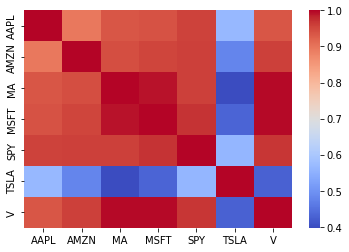

In [26]:
# Function to read CSV files from the specified folder path and extract 'Adj Close' prices
def read_csv_close(folder_path = './data/'):
    df_close = pd.DataFrame()
    for file in os.listdir(folder_path):
        df_read = pd.read_csv(f'{folder_path}{file}', index_col=0)
        df_ticker = df_read['Adj Close']
        df_ticker.name = file.replace('.csv', '')
        df_close = pd.concat([df_close,df_ticker] , axis=1)
    return df_close.dropna()

# Function to plot the correlation heatmap for different tickers within a specified date range
def plot_correlation(df, start_date='1900-01-01', end_date='2025-01-01'):
    df = df.copy()[start_date:end_date]
    corr = df.corr()
    sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, cmap='coolwarm')

start_date='2015-01-01'
end_date='2020-01-01'
plot_correlation(read_csv_close()[start_date:end_date])


In [31]:
# Function to implement pairs trading strategy, calculate metrics and visualize the results
def pairs_trading_strategy(df_close, ticker1, ticker2, strategy_start_date, strategy_end_date, entry_threshold=1.0, historical_start_date='1900-01-01'):
    # Get prices of assets  from dataframe
    df_tickers = df_close[[ticker1, ticker2]].copy()

    # Calculate percentage change spread between the two assets
    spread = df_tickers[ticker1].pct_change() - df_tickers[ticker2].pct_change()

    # Calculate z-score of the spread. Mean and standard deviation are calculated using historical data from historical_start_date to start_date
    zscore = ((spread - spread[historical_start_date:strategy_start_date].mean()) / spread[historical_start_date:strategy_start_date].std())

    # Slicing dataframe to only consider testing data
    zscore = zscore[strategy_start_date:strategy_end_date]
    df_tickers = df_tickers[strategy_start_date:strategy_end_date]

    # Initialize positions
    df_tickers[f'Position{ticker1}'] = 0
    df_tickers[f'Position{ticker2}'] = 0

    # Implement pairs trading strategy
    for i in range(len(zscore)):
        if zscore[i] > entry_threshold:
            # Short ticker1 and long ticker2
            df_tickers.loc[df_tickers.index[i], f'Position{ticker1}'] = -1
            df_tickers.loc[df_tickers.index[i], f'Position{ticker2}'] = 1
        elif zscore[i] < -entry_threshold:
            # Long ticker1 and short ticker2
            df_tickers.loc[df_tickers.index[i], f'Position{ticker1}'] = 1
            df_tickers.loc[df_tickers.index[i], f'Position{ticker2}'] = -1
        else:
            # Clear positions if z-score reverts to within entry_threshold
            df_tickers.loc[df_tickers.index[i], f'Position{ticker1}'] = 0
            df_tickers.loc[df_tickers.index[i], f'Position{ticker2}'] = 0

    # Calculate daily returns based on positions
    df_tickers[f'DailyReturn{ticker1}'] = df_close[ticker1].pct_change() * df_tickers[f'Position{ticker1}'].shift(1)
    df_tickers[f'DailyReturn{ticker2}'] = df_close[ticker2].pct_change() * df_tickers[f'Position{ticker2}'].shift(1)

    # Calculate total cumulative returns for pairs trading strategy (sum of both assets' returns)
    df_tickers['TotalDailyReturn'] = (1 + (df_tickers[f'DailyReturn{ticker1}'] + df_tickers[f'DailyReturn{ticker2}'])).cumprod()

    # Calculate cumulative returns for hold strategy
    df_tickers[f'CumulativeReturn{ticker1}'] = (1 + df_tickers[ticker1].pct_change()).cumprod()
    df_tickers[f'CumulativeReturn{ticker2}'] = (1 + df_tickers[ticker2].pct_change()).cumprod()

    # Calculate RoI %
    df_tickers[f'RoI%{ticker1}'] = 100 * (df_tickers[f'CumulativeReturn{ticker1}']-1)
    df_tickers[f'RoI%{ticker2}'] = 100 * (df_tickers[f'CumulativeReturn{ticker2}']-1)
    df_tickers['RoI%Total'] = 100 * (df_tickers['TotalDailyReturn']-1)
    
    # Filling NaN values with 0
    df_tickers = df_tickers.fillna(0)

    # Print metrics DataFrame
    list_name = ['Pairs Trading', "B&H "+ticker1, "B&H "+ticker2]
    list_results = [df_tickers['RoI%Total'].to_frame(), df_tickers[f'RoI%{ticker1}'].to_frame(), df_tickers[f'RoI%{ticker2}'].to_frame()]
    print(evaluation_df(list_name, list_results))

    # Plot the total daily return
    plt.figure(figsize=(16, 4))
    # Plot hold strategy for ticker1 and ticker2
    df_tickers[f'RoI%{ticker1}'].plot(label=f'B&H {ticker1}', linewidth=1)
    df_tickers[f'RoI%{ticker2}'].plot(label=f'B&H {ticker2}', linewidth=1)
    # Plot pairs trading strategy 
    df_tickers['RoI%Total'].plot(label='Pairs Trading', linewidth=2)
    plt.title(f'Pairs Trading Strategy\n{ticker1} vs {ticker2}')
    plt.xlabel('Date')
    plt.ylabel('Return on Investment %')
    plt.legend()
    plt.show()



Correlation coefficient between MA and V: 0.996

                Pairs Trading  B&H MA  B&H V
RoI %                   20.78   18.28  15.15
MaxDrawDown %           -9.69  -41.00 -36.36
Expected RoI %           0.08    0.11   0.09
Volatility %             0.01    0.15   0.14
Sharpe Ratio             5.99    0.75   0.66


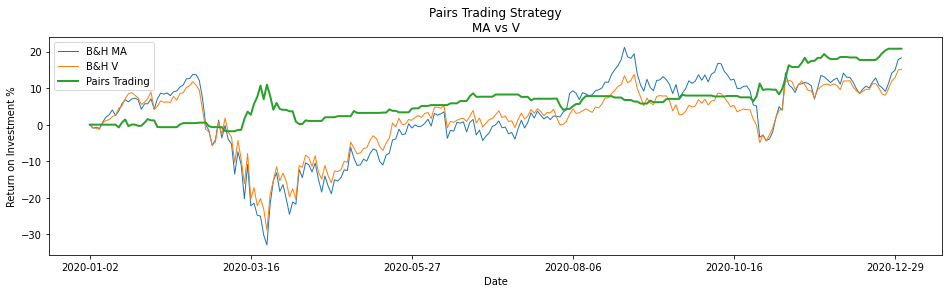

In [38]:
# Define two tickers
ticker1 = 'MA'
ticker2 = 'V'

# Define start and end dates for strategy testing
strategy_start_date = '2020-01-01'
strategy_end_date = '2021-01-01'

# Define entry threshold (in terms of z-score)
entry_threshold = 1

# Define the date for calculating mean and standard deviation (from historical_start_date to strategy_start_date)
historical_start_date = '2019-01-01'

# Get Close price data
df_close = read_csv_close()

# Calculate correlation
correlation = df_close[ticker1].corr(df_close[ticker2])
print(f"Correlation coefficient between {ticker1} and {ticker2}: {round(correlation,3)}\n")

# Perform pairs trading strategy
pairs_trading_strategy(df_close, ticker1, ticker2, strategy_start_date, strategy_end_date, entry_threshold, historical_start_date)